## SageMaker Jumpstart

- tabular, time series, image, text 등 다양한 task에 대한 모델을 가지고 있습니다.
- 기본적인 부분은 sagemaker의 built-in algorithm과 비슷합니다.
- 최근에 많이 추가된 기능은 Foundation model 과 관련된 내용들로, Large Language Model, Generative AI 등을 쉽게 사용할 수가 있습니다.


### Stable diffusion fine tuning 진행

- 내가 원하는 이미지를 생성하는 예시
- 블로그 참고 : https://aws.amazon.com/ko/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/
- 예시 노트북 : https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/Amazon_JumpStart_Text_To_Image.ipynb
  - 데이터 준비 예시 : https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/custom_dog_image_generator.ipynb



In [1]:
import sagemaker, boto3, json
from sagemaker.session import Session
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.estimator import Estimator
from sagemaker import hyperparameters

sagemaker_session = Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket = sagemaker_session.default_bucket()
print(bucket)

sagemaker-us-west-2-723597067299


In [3]:
# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
# training_instance_type = "ml.g5.2xlarge"
training_instance_type = "ml.g4dn.2xlarge"   # seoul region은 g5 없음

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

In [4]:
print(train_image_uri)
print(train_source_uri)
print(train_model_uri)

763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/stabilityai/transfer_learning/txt2img/v1.0.1/sourcedir.tar.gz
s3://jumpstart-cache-prod-us-west-2/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


In [6]:
# Retrieve the default hyper-parameters for fine-tuning the model
hyper_params = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyper_params["max_steps"] = "200"   # 높일수록 더 해당 사진과 비슷한 형태가 되지만, overfiting 될 수 있음.
# hyper_params["with_prior_preservation"] = "True"  # it needs more memory

In [7]:
print(hyper_params)

{'epochs': '20', 'max_steps': '200', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'seed': '0'}


In [8]:
from sagemaker.utils import name_from_base

s3_output_location = f"s3://{bucket}/lowcode-sm/logs/sd-fd-output/"
training_job_name = name_from_base(f"sd-fine-tuning-{train_model_id}")
print(training_job_name)

sd-fine-tuning-model-txt2img-stabilitya-2023-03-16-12-57-33-698


In [9]:

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyper_params,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)


In [10]:

import os
import json
import random
import shutil

test_dir = "data/wwi-dataset/test"
label_list = os.listdir(test_dir)
print(label_list)

['stonehenge', 'great_wall_of_china', 'statue_of_liberty', 'burj_khalifa', 'roman_colosseum', 'venezuela_angel_falls', 'machu_pichu', 'taj_mahal', 'chichen_itza', 'christ_the_reedemer', 'eiffel_tower', 'pyramids_of_giza']


In [11]:
label = "stonehenge"

dir_path = f"./sd-ft/{label}"
os.makedirs(dir_path, exist_ok=True)
instance_prompt = "A photo of my grandfather's home"
with open(os.path.join(dir_path, "dataset_info.json"), "w") as f:
    f.write(json.dumps({"instance_prompt": instance_prompt}))

test_images = os.listdir(os.path.join(test_dir, label))
random.shuffle(test_images)

for test_image in test_images[:8]:
    img_path = os.path.join(test_dir, label, test_image)
    dst_path = os.path.join(dir_path, test_image)
    shutil.copyfile(img_path, dst_path)

In [12]:
train_s3_path = f"s3://{bucket}/lowcode-sm/sd-ft/{label}/"
!aws s3 cp --exclude ".ipynb_checkpoints*" --recursive $dir_path $train_s3_path 

upload: sd-ft/stonehenge/b6cb2f50cc.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/b6cb2f50cc.jpg
upload: sd-ft/stonehenge/dataset_info.json to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/dataset_info.json
upload: sd-ft/stonehenge/29c059a1b9.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/29c059a1b9.jpg
upload: sd-ft/stonehenge/0e4083655e.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/0e4083655e.jpg
upload: sd-ft/stonehenge/e20ebd92be.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/e20ebd92be.jpg
upload: sd-ft/stonehenge/58990134c3.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/58990134c3.jpg
upload: sd-ft/stonehenge/1bc3588d4f.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/1bc3588d4f.jpg
upload: sd-ft/stonehenge/98c30c292f.jpg to s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/98c30c292f.jpg
up

In [13]:
print(train_s3_path)

s3://sagemaker-us-west-2-723597067299/lowcode-sm/sd-ft/stonehenge/


In [14]:
# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": train_s3_path}, logs=True)

INFO:sagemaker:Creating training-job with name: sd-fine-tuning-model-txt2img-stabilitya-2023-03-16-12-59-07-074


2023-03-16 12:59:07 Starting - Starting the training job...
2023-03-16 12:59:23 Starting - Preparing the instances for training......
2023-03-16 13:00:09 Downloading - Downloading input data............
2023-03-16 13:02:15 Training - Downloading the training image.........
2023-03-16 13:03:43 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-16 13:04:10,015 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-16 13:04:10,038 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-16 13:04:10,040 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-16 13:04:10,909 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerate/ac

In [15]:
# training_job_name = "[training job 이름]"
# sd_estimator = Estimator.attach(training_job_name)

In [16]:
inference_instance_type = "ml.g4dn.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"sd-ft-{train_model_id}-")


In [17]:
print(deploy_image_uri)
print(deploy_source_uri)


763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz


In [18]:

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)
# print(finetuned_predictor)


INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-03-16-13-20-38-618
INFO:sagemaker:Creating endpoint-config with name sd-ft-model-txt2img-stabilityai-stable--2023-03-16-13-20-38-610
INFO:sagemaker:Creating endpoint with name sd-ft-model-txt2img-stabilityai-stable--2023-03-16-13-20-38-610


----------!

In [19]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

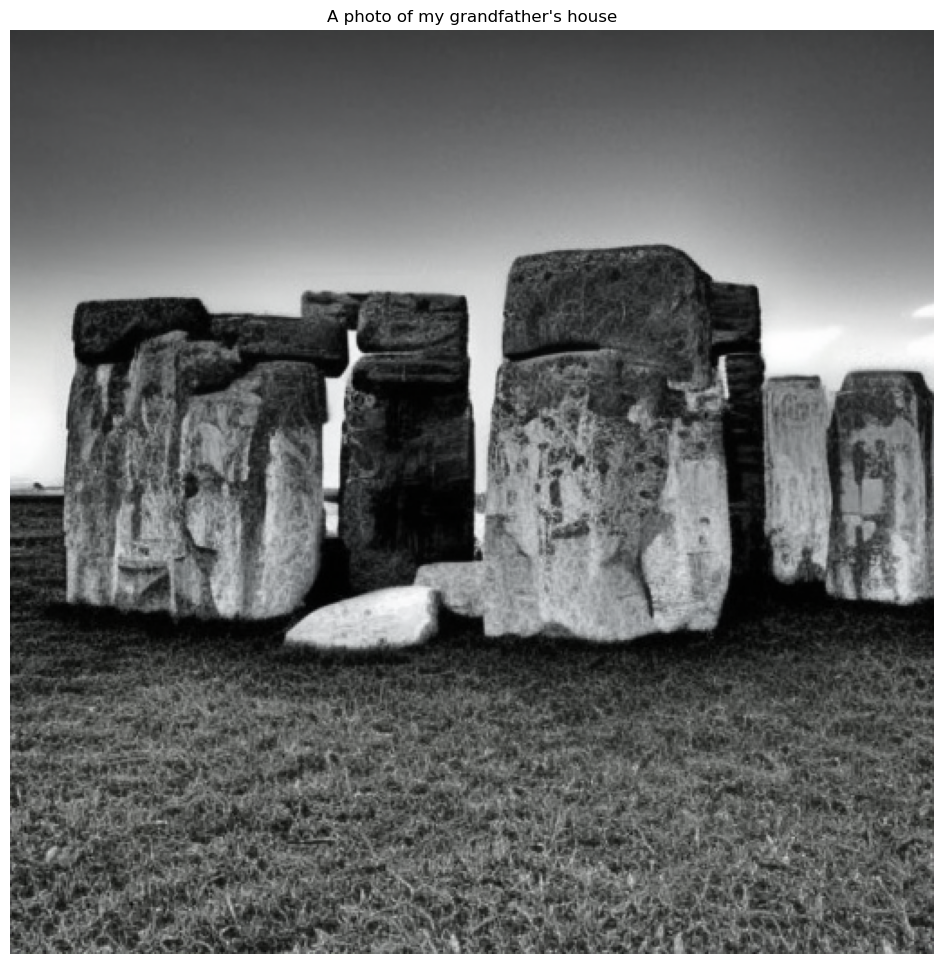

In [20]:
text = "A photo of my grandfather's house"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

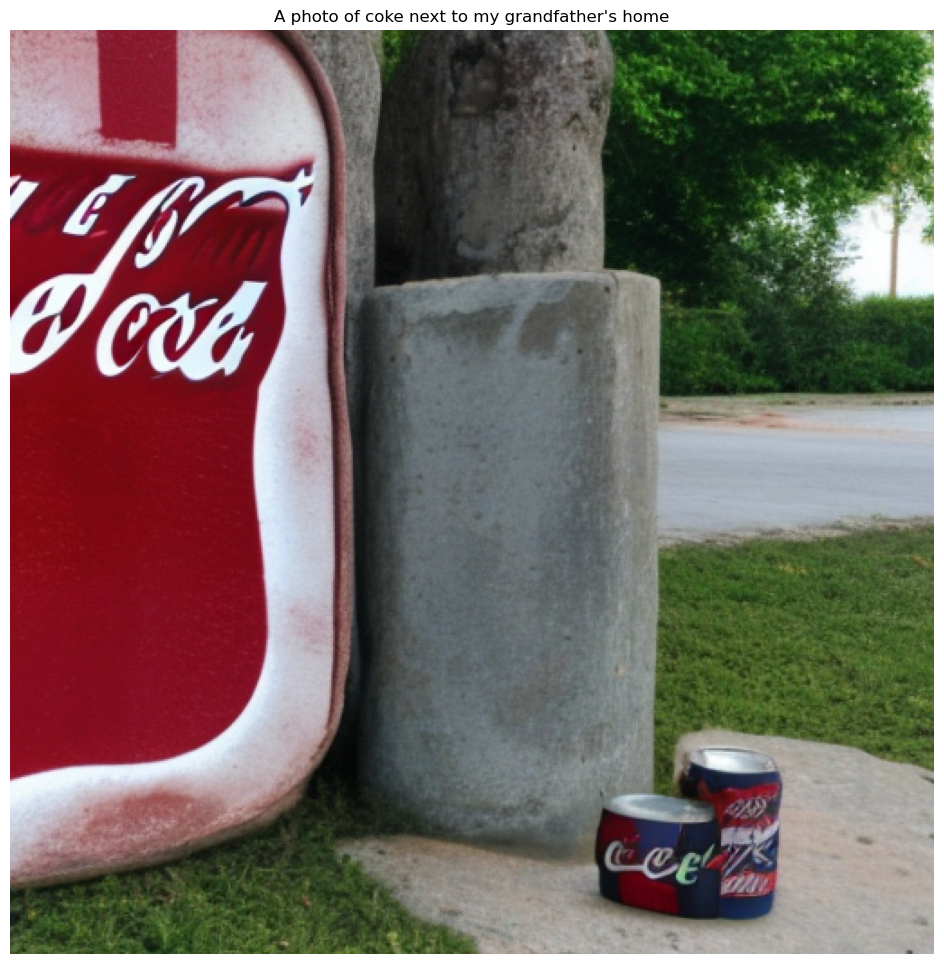

In [21]:
text = "A photo of coke next to my grandfather's home"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)